In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline  import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split


In [39]:
train = pd.read_csv('./titanic/train.csv')
test = pd.read_csv('./titanic/test.csv')

In [40]:
train_dummies = pd.get_dummies(train, columns=['Sex', 'Pclass', 'Embarked'])
test_dummies = pd.get_dummies(test, columns=['Sex', 'Pclass', 'Embarked'])

In [41]:
X_train = train_dummies.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
X_test = test_dummies.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [5]:
y_train = train_dummies['Survived']

In [6]:
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)
X_train_fit = imputer.fit_transform(X_train)

In [7]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
X_train_scaled = scaler.fit_transform(X_train_fit)

In [134]:
X_test_fit = imputer.fit_transform(X_test)

In [135]:

X_test_scaled = scaler.fit_transform(X_test_fit)


# Подбор параметров модели

In [8]:
kfold = KFold(n_splits=3, shuffle=True, random_state=145)

In [9]:
pipeline = Pipeline(steps=[ ('imputer', imputer),
                            ('scale', scaler),
                           ('model', DecisionTreeClassifier() )] )

param_grid = {'model__max_depth': list(range(2, 5, 1)), 
              'model__min_samples_leaf' : list(range(1, 10, 1)), 
              'model__max_features': list(range(1, 10, 1)),
              'model__criterion': ['gini', 'entropy'], 
             'model__min_samples_split' : list( range(2, 10, 1) )}

grid = GridSearchCV(pipeline, param_grid, 
                    scoring='accuracy',
                    cv=kfold)

In [10]:
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=145, shuffle=True),
       error_score='raise',
       estimator=Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=Non...t=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'model__max_depth': [2, 3, 4], 'model__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'model__max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'model__criterion': ['gini', 'entropy'], 'model__min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [11]:
model = grid.fit(X_train_scaled, y_train)
model.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 4,
 'model__max_features': 6,
 'model__min_samples_leaf': 4,
 'model__min_samples_split': 9}

In [12]:
model.best_score_

0.82491582491582494

In [13]:
scores = cross_val_score(model, X_train_scaled, y_train, cv = kfold, scoring='accuracy')

In [14]:
np.average(scores)

0.78900112233445563

# Генерация файла 

In [136]:
predictedFinal = model.predict(X_test_scaled)

In [137]:
with open('submission_tree02.csv', 'w') as out:
    out.write('PassengerId,Survived\n')
    for passenger, y in zip(test['PassengerId'], predictedFinal):
        out.write('%s,%s\n' % (passenger, y))

# Проверка качества модели, метрики модели

In [162]:
y_predicted = model.predict(X_train_scaled)
y_predicted_proba = model.predict_proba(X_train_scaled)

In [163]:
from sklearn import metrics

def auc_prc(train, predicted, predicted_proba ): 
    accuracy = metrics.accuracy_score( y_train, y_predicted )
    precision = metrics.precision_score( y_train, y_predicted ) 
    recall = metrics.recall_score( y_train, y_predicted ) 
    roc_auc = metrics.roc_auc_score( y_train, y_predicted_proba[:, 1] )
    prc_auc = metrics.average_precision_score( y_train, y_predicted_proba[:, 1] )
    
    pr, re, thres = metrics.precision_recall_curve(train, predicted_proba)
    fpr, tpr, thres2 = metrics.roc_curve( train, predicted_proba)
    
    
    print('accuracy = ', accuracy, sep='\t')
    print('precision = ', precision, sep='\t')
    print('recall = ', recall, sep='\t')
    print('roc_auc = ', roc_auc, sep='\t')
    print('prc_auc = ', prc_auc, sep='\t')       


In [164]:
auc_prc( y_train, y_predicted, y_predicted_proba[:, 1] )

accuracy = 	0.83164983165
precision = 	0.815789473684
recall = 	0.72514619883
roc_auc = 	0.883879781421
prc_auc = 	0.870680343657


In [165]:
pr, re, thres = metrics.precision_recall_curve(y_train, y_predicted_proba[:, 1] )
fpr, tpr, thres2 = metrics.roc_curve( y_train, y_predicted_proba[:, 1])

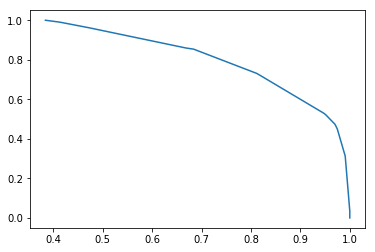

In [167]:
plt.plot(pr, re)

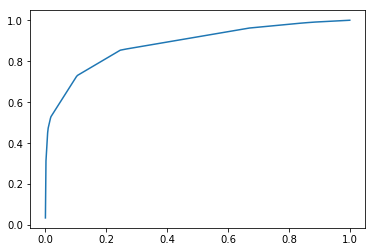

In [166]:
plt.plot(fpr, tpr)

# Определение важности признаков

In [52]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=4, 
                             max_features=6, min_samples_leaf=4, 
                             min_samples_split=9)

In [53]:
clf.fit(X_train_scaled, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=4, min_samples_split=9,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [102]:
f_list = list(clf.feature_importances_)
name_list = list(X_train.columns)
f_list, name_list


([0.069539678600846741,
  0.038788896313272869,
  0.019305065051666771,
  0.050084127171947573,
  0.44242857449624401,
  0.13336705974889193,
  0.0,
  0.0,
  0.2158638311048455,
  0.0,
  0.0,
  0.030622767512284748],
 ['Age',
  'SibSp',
  'Parch',
  'Fare',
  'Sex_female',
  'Sex_male',
  'Pclass_1',
  'Pclass_2',
  'Pclass_3',
  'Embarked_C',
  'Embarked_Q',
  'Embarked_S'])

Sex_female , Pclass_3 - признаки наиболее важные из остальных

# Визуализация

In [103]:
from sklearn.tree import export_graphviz

In [104]:
def get_tree_dot_view(clf, feature_names=None, class_names=None):
    print(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))

In [116]:
get_tree_dot_view( clf, feature_names=list(X_train.columns), class_names=['Not Survived','Survived'] )

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="Pclass_3 <= -0.1027\ngini = 0.473\nsamples = 891\nvalue = [549, 342]\nclass = Not Survived", fillcolor="#e5813960"] ;
1 [label="Sex_female <= 0.3089\ngini = 0.4934\nsamples = 400\nvalue = [177, 223]\nclass = Survived", fillcolor="#399de535"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="Fare <= -0.1195\ngini = 0.3938\nsamples = 230\nvalue = [168, 62]\nclass = Not Survived", fillcolor="#e58139a1"] ;
1 -> 2 ;
3 [label="Parch <= 0.147\ngini = 0.2262\nsamples = 100\nvalue = [87, 13]\nclass = Not Survived", fillcolor="#e58139d9"] ;
2 -> 3 ;
4 [label="gini = 0.1604\nsamples = 91\nvalue = [83, 8]\nclass = Not Survived", fillcolor="#e58139e6"] ;
3 -> 4 ;
5 [label="gini = 0.4938\nsamples = 9\nvalue = [4, 5]\nclass = Survived", fillcolor="#399de533"] ;
3 -> 5 ;
6 [label="Age <= -0.9388\ngini = 0.4697\nsamples = 130\nvalue = [81, 49]\nclass = Not Survived", fillcolor="#e5813965"] ;
2 -> 6 ;
7 [l